## Importing the Data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data_ramen = pd.read_csv("ramen-ratings.csv")

print(data_ramen.head())

   Review #           Brand  ... Stars Top Ten
0      2580       New Touch  ...  3.75     NaN
1      2579        Just Way  ...     1     NaN
2      2578          Nissin  ...  2.25     NaN
3      2577         Wei Lih  ...  2.75     NaN
4      2576  Ching's Secret  ...  3.75     NaN

[5 rows x 7 columns]


## Looking at the Review Column as Index

In [4]:
data_ramen.set_index("Review #", inplace=True)

print(data_ramen.head())

                   Brand  ... Top Ten
Review #                  ...        
2580           New Touch  ...     NaN
2579            Just Way  ...     NaN
2578              Nissin  ...     NaN
2577             Wei Lih  ...     NaN
2576      Ching's Secret  ...     NaN

[5 rows x 6 columns]


## Looking at Stars Column

In [5]:
print(data_ramen["Stars"].unique()) # we can see her ethat we have unrated, we need to fix it

['3.75' '1' '2.25' '2.75' '4.75' '4' '0.25' '2.5' '5' '4.25' '4.5' '3.5'
 'Unrated' '1.5' '3.25' '2' '0' '3' '0.5' '4.00' '5.0' '3.50' '3.8' '4.3'
 '2.3' '5.00' '3.3' '4.0' '3.00' '1.75' '3.0' '4.50' '0.75' '1.25' '1.1'
 '2.1' '0.9' '3.1' '4.125' '3.125' '2.125' '2.9' '0.1' '2.8' '3.7' '3.4'
 '3.6' '2.85' '3.2' '3.65' '1.8']


In [6]:
# stars column is stored as text, so we will need to turn it into numeric 

data_ramen["Stars"] = pd.to_numeric(data_ramen["Stars"], errors='coerce') # this will turn all our unrated into NAN
print(data_ramen["Stars"].dtype) 
print('number of Unrated found:', data_ramen["Stars"].isnull().sum())

float64
number of Unrated found: 3


In [7]:
print(data_ramen.isnull().sum()) # check of all missing values now

Brand         0
Variety       0
Style         2
Country       0
Stars         3
Top Ten    2539
dtype: int64


In [8]:
data_ramen.drop(columns="Top Ten", inplace=True) # I decided to just drop the top ten column cause it all missing

print(data_ramen.columns)

Index(['Brand', 'Variety', 'Style', 'Country', 'Stars'], dtype='object')


In [9]:
data_ramen.dropna(inplace=True) # just dropped missing values cause there are not a lot of them

print(data_ramen.shape) # total was 2580 (5 droped 2 for style and 3 for stars) we left with 2575

(2575, 5)


# Train-Test Split

In [10]:
X = data_ramen.drop(columns="Stars")
y = data_ramen["Stars"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2060, 4)
Test shape: (515, 4)


## Feature types

In [11]:
# no Numercial features mainly 
#categorical_features = ["Brand", "Style", "Country"]

l_m_cardinal = ["Style", "Country"] # I decided to change the features due to the homework and here we have low + medium cardinality

high_cardinal = ["Brand"] # and here high cardinality

## Categorical Transformer

In [12]:
#categorical_transformer = Pipeline(steps=[
#    ("imputer", SimpleImputer(strategy="most_frequent")),
#    ("encoder", OneHotEncoder(handle_unknown="ignore"))
#])

l_m_cardinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [13]:
high_cardinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [14]:
#preprocessor = ColumnTransformer(
 #   transformers=[
  #      ("cat", categorical_transformer, categorical_features)
   # ],
    #remainder="drop"  
#)

# the new version for the homework 
preprocessor = ColumnTransformer(transformers=[
    ("onehot", l_m_cardinal_transformer, l_m_cardinal),
    ("ordinal", high_cardinal_transformer, high_cardinal)
])

## Final Pipeline with Preprocessing

In [15]:
from sklearn.ensemble import RandomForestRegressor

model_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## Now lets Evaluate the Model

In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.70
MSE: 0.92
R² Score: 0.08


## Visualization

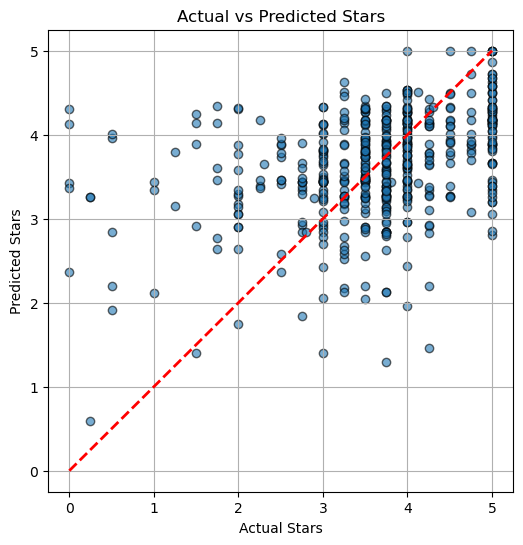

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Stars")
plt.ylabel("Predicted Stars")
plt.title("Actual vs Predicted Stars")
plt.grid(True)
plt.show()